# Skin Cancer Detection using Deep Learning
## ISIC 2024 Challenge - 3D Total Body Photography

**Course:** DTSA 5511 - Introduction to Deep Learning  
**Project Type:** Final Project  
**Dataset:** SLICE-3D (Skin Lesion Image Crops Extracted from 3D TBP)

## 1. Introduction and Problem Definition

Skin cancer is one of the most common types of cancer worldwide, with melanoma being the deadliest form. Early detection is crucial for successful treatment, but access to specialized dermatologic care is limited in many regions. This project aims to develop a deep learning model that can classify skin lesions as benign or malignant based on images extracted from 3D total body photography.

The dataset used in this project comes from the ISIC 2024 Challenge and contains over 400,000 skin lesion images from patients across multiple continents. Unlike traditional dermoscopy images, these images resemble smartphone photos, making the classification task more challenging but also more applicable to real-world telemedicine scenarios.

A critical characteristic of this dataset is the extreme class imbalance: only about 0.1% of all samples are malignant (393 out of 401,059). This creates a "needle in a haystack" problem where a naive classifier could achieve 99.9% accuracy by simply predicting everything as benign, while being completely useless for actual cancer detection.

The evaluation metric used is the partial area under the ROC curve (pAUC) above 80% true positive rate, which is clinically relevant since skin cancer detection systems need to be highly sensitive.

In this notebook, I explore multiple approaches and address key methodological challenges:
1. Proper patient-level data splitting to prevent data leakage
2. Handling extreme class imbalance through sampling and loss weighting strategies
3. Comparing image-only, tabular-only, and multimodal approaches
4. Cross-validation for robust evaluation
5. Feature importance analysis for model interpretability

## 2. Setup and Data Loading

In this section, I import all necessary libraries and load the dataset. The images are stored in HDF5 format which allows efficient access to large amounts of image data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from PIL import Image
import io
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
BASE_PATH = "/kaggle/input/isic-2024-challenge"
TRAIN_META = f"{BASE_PATH}/train-metadata.csv"
TRAIN_HDF5 = f"{BASE_PATH}/train-image.hdf5"

train_df = pd.read_csv(TRAIN_META)
print(f"Dataset shape: {train_df.shape}")
print(f"Number of features: {len(train_df.columns)}")

Dataset shape: (401059, 55)
Number of features: 55


## 3. Exploratory Data Analysis

This section contains a thorough analysis of the dataset. Understanding the extreme class imbalance and feature distributions is essential before building any model.

### 3.1 Target Distribution and Class Imbalance

The dataset exhibits extreme class imbalance which is typical for medical screening datasets where the condition being detected is rare.

Target distribution:
target
0    400666
1       393
Name: count, dtype: int64

Class imbalance ratio: 1019.5:1
Percentage of malignant cases: 0.098%


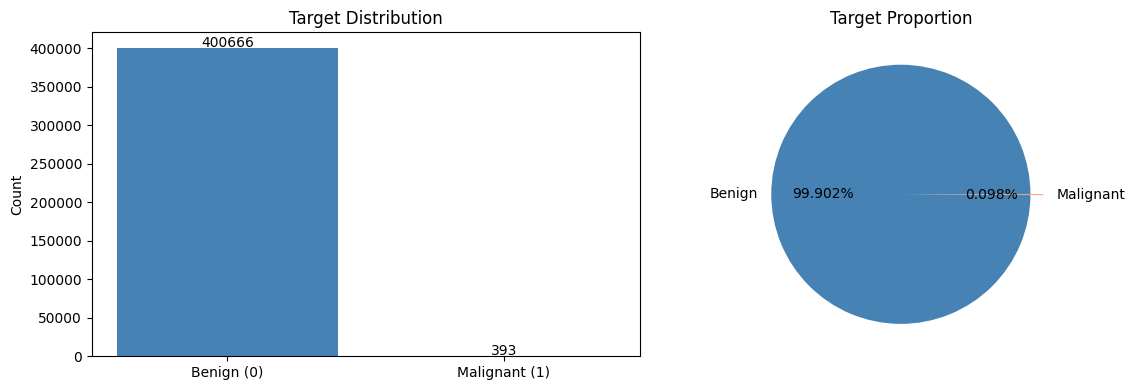

In [3]:
target_counts = train_df['target'].value_counts()
print("Target distribution:")
print(target_counts)
print(f"\nClass imbalance ratio: {target_counts[0] / target_counts[1]:.1f}:1")
print(f"Percentage of malignant cases: {target_counts[1] / len(train_df) * 100:.3f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Benign (0)', 'Malignant (1)'], target_counts.values, color=['steelblue', 'coral'])
axes[0].set_ylabel('Count')
axes[0].set_title('Target Distribution')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 1000, str(v), ha='center')

axes[1].pie(target_counts.values, labels=['Benign', 'Malignant'], autopct='%1.3f%%', 
            colors=['steelblue', 'coral'], explode=[0, 0.1])
axes[1].set_title('Target Proportion')

plt.tight_layout()
plt.show()

The ratio of approximately 1000:1 presents a significant challenge. A model that simply predicts "benign" for everything would achieve 99.9% accuracy but would be clinically useless. This is why we focus on AUC and pAUC metrics instead of accuracy.

### 3.2 Missing Values Analysis

In [4]:
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False)

print("Columns with missing values:")
print(missing_df.head(15))

Columns with missing values:
                     Missing Count  Percentage
iddx_5                      401058   99.999751
mel_mitotic_index           401006   99.986785
mel_thick_mm                400996   99.984292
iddx_4                      400508   99.862614
iddx_3                      399994   99.734453
iddx_2                      399991   99.733705
lesion_id                   379001   94.500061
sex                          11517    2.871647
anatom_site_general           5756    1.435200
age_approx                    2798    0.697653


The diagnostic columns (iddx_1-5, mel_mitotic_index, mel_thick_mm) have very high missing rates because they are only available for biopsied lesions. These cannot be used for prediction since they would not be available at inference time.

### 3.3 Patient Demographics and Distribution

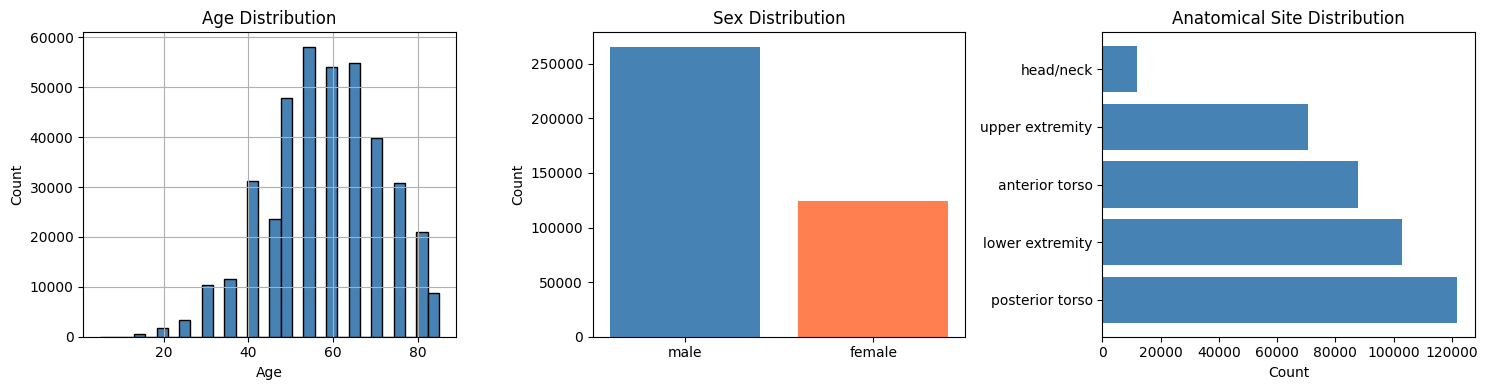

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_df['age_approx'].hist(bins=30, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Age Distribution')

sex_counts = train_df['sex'].value_counts()
axes[1].bar(sex_counts.index, sex_counts.values, color=['steelblue', 'coral'])
axes[1].set_ylabel('Count')
axes[1].set_title('Sex Distribution')

site_counts = train_df['anatom_site_general'].value_counts()
axes[2].barh(site_counts.index, site_counts.values, color='steelblue')
axes[2].set_xlabel('Count')
axes[2].set_title('Anatomical Site Distribution')

plt.tight_layout()
plt.show()

### 3.4 Malignancy Rate by Demographics

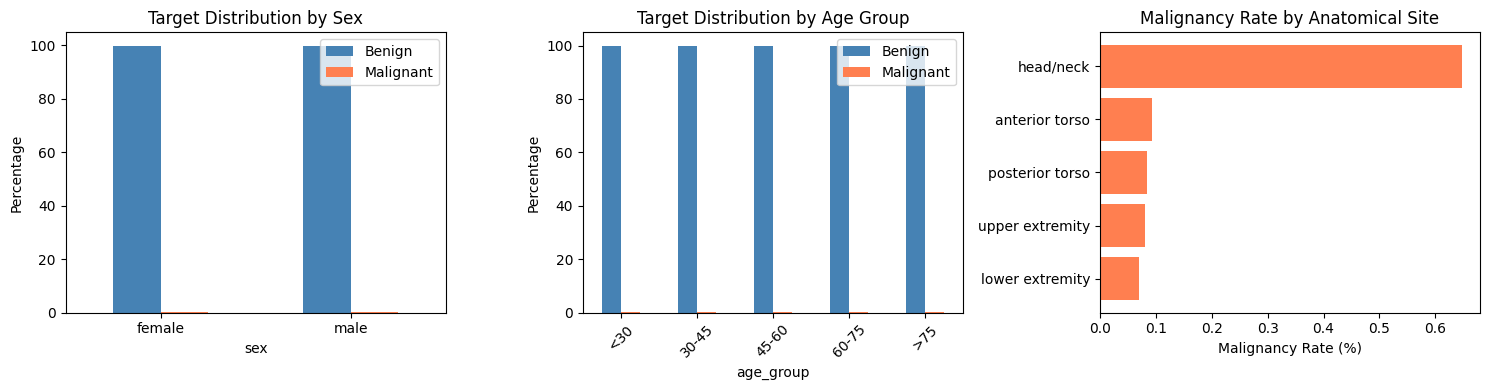

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sex_target = train_df.groupby(['sex', 'target']).size().unstack(fill_value=0)
sex_target_pct = sex_target.div(sex_target.sum(axis=1), axis=0) * 100
sex_target_pct.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_ylabel('Percentage')
axes[0].set_title('Target Distribution by Sex')
axes[0].legend(['Benign', 'Malignant'])
axes[0].tick_params(axis='x', rotation=0)

train_df['age_group'] = pd.cut(train_df['age_approx'], bins=[0, 30, 45, 60, 75, 100], 
                               labels=['<30', '30-45', '45-60', '60-75', '>75'])
age_target = train_df.groupby(['age_group', 'target']).size().unstack(fill_value=0)
age_target_pct = age_target.div(age_target.sum(axis=1), axis=0) * 100
age_target_pct.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_ylabel('Percentage')
axes[1].set_title('Target Distribution by Age Group')
axes[1].legend(['Benign', 'Malignant'])
axes[1].tick_params(axis='x', rotation=45)

site_target = train_df.groupby(['anatom_site_general', 'target']).size().unstack(fill_value=0)
site_target_pct = site_target.div(site_target.sum(axis=1), axis=0) * 100
site_target_pct['Malignant'] = site_target_pct[1]
site_target_pct = site_target_pct.sort_values('Malignant', ascending=True)
axes[2].barh(site_target_pct.index, site_target_pct[1], color='coral')
axes[2].set_xlabel('Malignancy Rate (%)')
axes[2].set_title('Malignancy Rate by Anatomical Site')

plt.tight_layout()
plt.show()

### 3.5 ABCDE Features Analysis

The dataset includes features that align with the ABCDE criteria used by dermatologists for melanoma detection. These features are automatically computed by the Vectra imaging system.

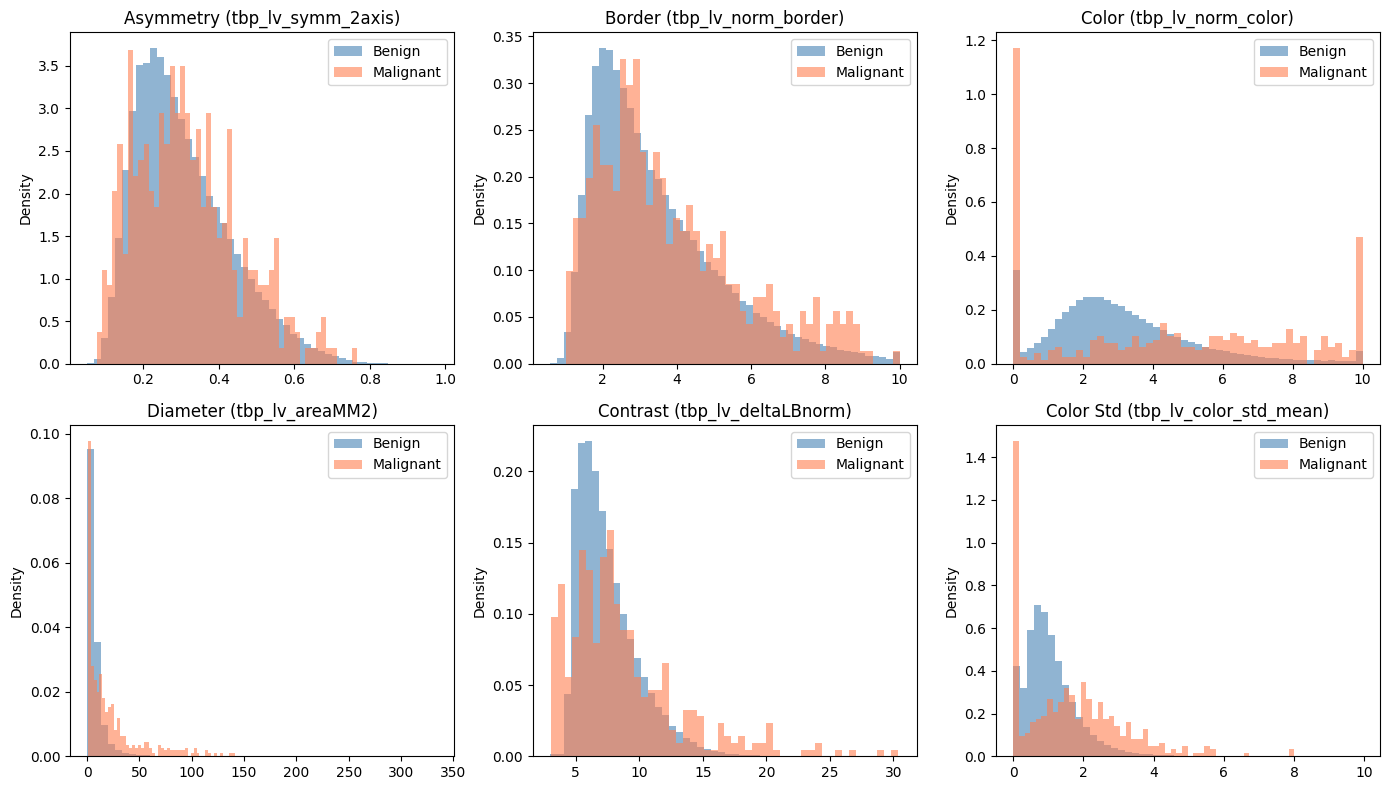

In [7]:
abcde_features = {
    'Asymmetry': 'tbp_lv_symm_2axis',
    'Border': 'tbp_lv_norm_border',
    'Color': 'tbp_lv_norm_color',
    'Diameter': 'tbp_lv_areaMM2',
    'Contrast': 'tbp_lv_deltaLBnorm',
    'Color Std': 'tbp_lv_color_std_mean'
}

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, (name, col) in enumerate(abcde_features.items()):
    if col in train_df.columns:
        benign_data = train_df[train_df['target'] == 0][col].dropna()
        malignant_data = train_df[train_df['target'] == 1][col].dropna()
        
        axes[idx].hist(benign_data, bins=50, alpha=0.6, label='Benign', color='steelblue', density=True)
        axes[idx].hist(malignant_data, bins=50, alpha=0.6, label='Malignant', color='coral', density=True)
        axes[idx].set_title(f'{name} ({col})')
        axes[idx].legend()
        axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

### 3.6 Feature Correlations with Target

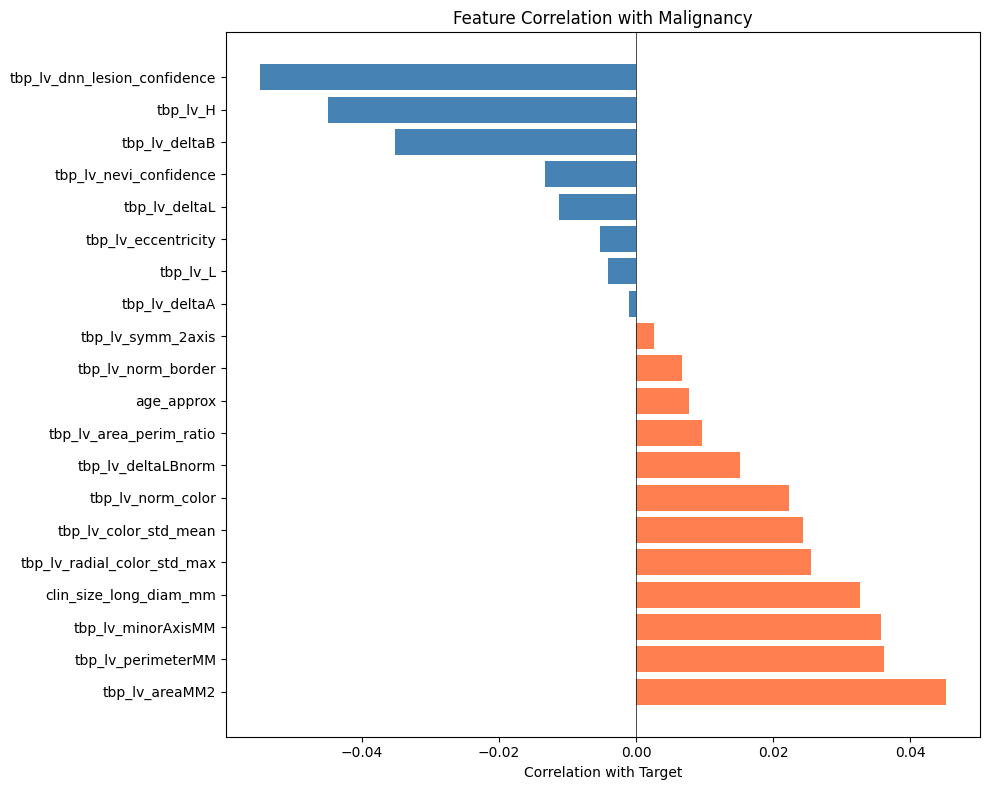


Top 5 positive correlations:
tbp_lv_areaMM2                 0.045139
tbp_lv_perimeterMM             0.036188
tbp_lv_minorAxisMM             0.035757
clin_size_long_diam_mm         0.032682
tbp_lv_radial_color_std_max    0.025441
Name: target, dtype: float64

Top 5 negative correlations:
tbp_lv_deltaL                  -0.011256
tbp_lv_nevi_confidence         -0.013341
tbp_lv_deltaB                  -0.035069
tbp_lv_H                       -0.044884
tbp_lv_dnn_lesion_confidence   -0.054766
Name: target, dtype: float64


In [8]:
tabular_candidates = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_perimeterMM',
    'tbp_lv_minorAxisMM', 'tbp_lv_eccentricity', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_symm_2axis', 'tbp_lv_color_std_mean', 'tbp_lv_deltaLBnorm', 'tbp_lv_deltaL',
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_L', 'tbp_lv_H', 'tbp_lv_area_perim_ratio',
    'tbp_lv_nevi_confidence', 'tbp_lv_dnn_lesion_confidence', 'tbp_lv_radial_color_std_max'
]

available_features = [f for f in tabular_candidates if f in train_df.columns]
corr_with_target = train_df[available_features + ['target']].corr()['target'].drop('target')
corr_with_target = corr_with_target.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
colors = ['coral' if x > 0 else 'steelblue' for x in corr_with_target.values]
plt.barh(corr_with_target.index, corr_with_target.values, color=colors)
plt.xlabel('Correlation with Target')
plt.title('Feature Correlation with Malignancy')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nTop 5 positive correlations:")
print(corr_with_target.head(5))
print("\nTop 5 negative correlations:")
print(corr_with_target.tail(5))

### 3.7 Sample Images

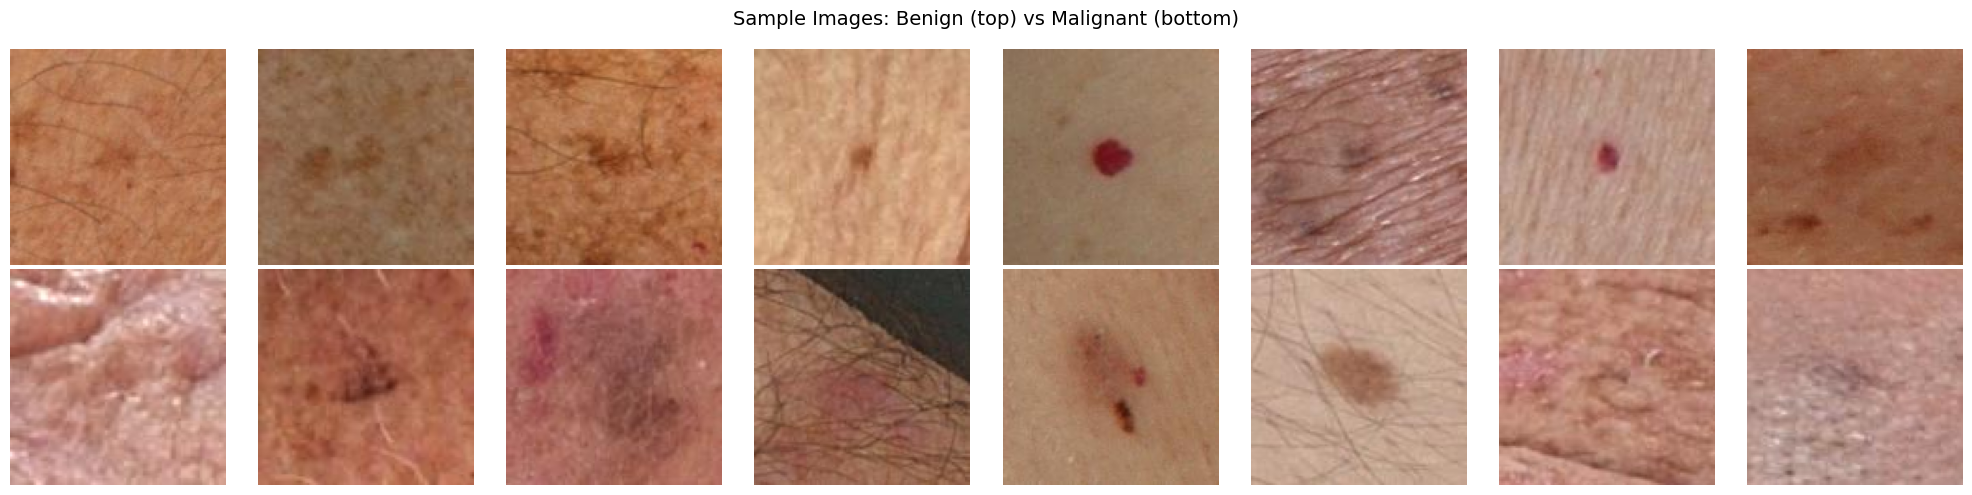

In [9]:
def load_image_from_hdf5(hdf5_path, isic_id):
    with h5py.File(hdf5_path, 'r') as f:
        img_data = f[isic_id][()]
        img = Image.open(io.BytesIO(img_data))
        return np.array(img)

benign_samples = train_df[train_df['target'] == 0].sample(8, random_state=42)['isic_id'].tolist()
malignant_samples = train_df[train_df['target'] == 1].sample(8, random_state=42)['isic_id'].tolist()

fig, axes = plt.subplots(2, 8, figsize=(20, 5))

for idx, isic_id in enumerate(benign_samples):
    img = load_image_from_hdf5(TRAIN_HDF5, isic_id)
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')

for idx, isic_id in enumerate(malignant_samples):
    img = load_image_from_hdf5(TRAIN_HDF5, isic_id)
    axes[1, idx].imshow(img)
    axes[1, idx].axis('off')

plt.suptitle('Sample Images: Benign (top) vs Malignant (bottom)', fontsize=14)
plt.tight_layout()
plt.show()

### 3.8 Patient-Level Analysis

Understanding the patient-level distribution is crucial for proper data splitting. Multiple lesions from the same patient must stay together to prevent data leakage.

In [10]:
patient_stats = train_df.groupby('patient_id').agg({
    'isic_id': 'count',
    'target': ['sum', 'max']
}).reset_index()
patient_stats.columns = ['patient_id', 'n_lesions', 'n_malignant', 'has_malignant']

print(f"Total number of patients: {len(patient_stats)}")
print(f"Patients with at least one malignant lesion: {patient_stats['has_malignant'].sum()}")
print(f"\nLesions per patient statistics:")
print(patient_stats['n_lesions'].describe())

Total number of patients: 1042
Patients with at least one malignant lesion: 259

Lesions per patient statistics:
count    1042.000000
mean      384.893474
std       540.268913
min         1.000000
25%       115.000000
50%       241.500000
75%       477.500000
max      9184.000000
Name: n_lesions, dtype: float64


## 4. Data Preprocessing

This section addresses key methodological considerations for proper data preparation, including patient-level splitting to prevent data leakage and strategic sampling approaches.

### 4.1 Sampling Strategy Discussion

When dealing with extreme class imbalance (1:1000), there are several approaches:

1. **Undersampling**: Reduce majority class samples
2. **Oversampling/Augmentation**: Increase minority class samples
3. **Loss weighting**: Penalize minority class errors more heavily
4. **Combination**: Use multiple techniques together

A common mistake is to apply both aggressive undersampling AND heavy loss weighting, which causes "double punishment" and leads to overly aggressive predictions (high recall but very low precision). In this notebook, I will experiment with different weighting strategies to find the right balance.

In [11]:
# Use a larger subset to give the model more data to learn from
N_SAMPLES = 80000

malignant_df = train_df[train_df['target'] == 1]
benign_df = train_df[train_df['target'] == 0]

n_malignant = len(malignant_df)
n_benign = N_SAMPLES - n_malignant

benign_sample = benign_df.sample(n=n_benign, random_state=42)
subset_df = pd.concat([malignant_df, benign_sample]).reset_index(drop=True)

print(f"Subset size: {len(subset_df)}")
print(f"Malignant samples: {n_malignant} ({n_malignant/len(subset_df)*100:.2f}%)")
print(f"Benign samples: {n_benign} ({n_benign/len(subset_df)*100:.2f}%)")
print(f"Effective ratio: 1:{n_benign/n_malignant:.0f}")

Subset size: 80000
Malignant samples: 393 (0.49%)
Benign samples: 79607 (99.51%)
Effective ratio: 1:203


### 4.2 Patient-Level Train/Validation Split

To prevent data leakage, I split by patient_id rather than randomly splitting images. This ensures that all lesions from the same patient are in either training or validation, but never both. Without this, the model might learn patient-specific features rather than generalizable cancer characteristics.

In [12]:
# Get unique patients
patients_with_malignant = subset_df[subset_df['target'] == 1]['patient_id'].unique()
patients_without_malignant = subset_df[~subset_df['patient_id'].isin(patients_with_malignant)]['patient_id'].unique()

# Stratified split by patient malignancy status
train_patients_mal, val_patients_mal = train_test_split(
    patients_with_malignant, test_size=0.2, random_state=42
)
train_patients_benign, val_patients_benign = train_test_split(
    patients_without_malignant, test_size=0.2, random_state=42
)

train_patients = np.concatenate([train_patients_mal, train_patients_benign])
val_patients = np.concatenate([val_patients_mal, val_patients_benign])

train_data = subset_df[subset_df['patient_id'].isin(train_patients)].reset_index(drop=True)
val_data = subset_df[subset_df['patient_id'].isin(val_patients)].reset_index(drop=True)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"\nTraining target distribution:")
print(train_data['target'].value_counts())
print(f"\nValidation target distribution:")
print(val_data['target'].value_counts())

# Verify no patient overlap
train_patient_set = set(train_data['patient_id'].unique())
val_patient_set = set(val_data['patient_id'].unique())
overlap = train_patient_set.intersection(val_patient_set)
print(f"\nPatient overlap between train and val: {len(overlap)} (should be 0)")

Training samples: 62477
Validation samples: 17523

Training target distribution:
target
0    62156
1      321
Name: count, dtype: int64

Validation target distribution:
target
0    17451
1       72
Name: count, dtype: int64

Patient overlap between train and val: 0 (should be 0)


### 4.3 Tabular Feature Preparation

In [13]:
TABULAR_FEATURES = [
    'age_approx',
    'clin_size_long_diam_mm',
    'tbp_lv_areaMM2',
    'tbp_lv_perimeterMM',
    'tbp_lv_minorAxisMM',
    'tbp_lv_eccentricity',
    'tbp_lv_norm_border',
    'tbp_lv_norm_color',
    'tbp_lv_symm_2axis',
    'tbp_lv_color_std_mean',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_deltaL',
    'tbp_lv_H',
    'tbp_lv_L',
    'tbp_lv_area_perim_ratio',
    'tbp_lv_nevi_confidence',
    'tbp_lv_radial_color_std_max',
]

CATEGORICAL_FEATURES = ['sex', 'anatom_site_general', 'tbp_lv_location_simple']

def prepare_tabular_data(df, fit_encoders=None, fit_scaler=None):
    df_processed = df.copy()
    
    for col in TABULAR_FEATURES:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    encoders = fit_encoders if fit_encoders else {}
    for col in CATEGORICAL_FEATURES:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('unknown')
            if col not in encoders:
                encoders[col] = LabelEncoder()
                df_processed[col + '_encoded'] = encoders[col].fit_transform(df_processed[col].astype(str))
            else:
                df_processed[col + '_encoded'] = df_processed[col].astype(str).apply(
                    lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
                )
    
    feature_cols = TABULAR_FEATURES + [col + '_encoded' for col in CATEGORICAL_FEATURES if col in df_processed.columns]
    available_cols = [col for col in feature_cols if col in df_processed.columns]
    
    X = df_processed[available_cols].values
    
    if fit_scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        scaler = fit_scaler
        X_scaled = scaler.transform(X)
    
    return X_scaled, encoders, scaler, available_cols

X_train_tab, encoders, scaler, feature_cols = prepare_tabular_data(train_data)
X_val_tab, _, _, _ = prepare_tabular_data(val_data, fit_encoders=encoders, fit_scaler=scaler)

print(f"Tabular features shape: {X_train_tab.shape}")
print(f"Features used: {feature_cols}")

Tabular features shape: (62477, 20)
Features used: ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_perimeterMM', 'tbp_lv_minorAxisMM', 'tbp_lv_eccentricity', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_symm_2axis', 'tbp_lv_color_std_mean', 'tbp_lv_deltaLBnorm', 'tbp_lv_deltaL', 'tbp_lv_H', 'tbp_lv_L', 'tbp_lv_area_perim_ratio', 'tbp_lv_nevi_confidence', 'tbp_lv_radial_color_std_max', 'sex_encoded', 'anatom_site_general_encoded', 'tbp_lv_location_simple_encoded']


## 5. Model Development

In this section, I develop multiple deep learning models and experiment with different loss weighting strategies to find the optimal balance between recall and precision.

### 5.1 Dataset Classes

In [14]:
class ImageOnlyDataset(Dataset):
    def __init__(self, df, hdf5_path, transform=None):
        self.df = df.reset_index(drop=True)
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.hdf5_file = None
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_path, 'r')
        
        isic_id = self.df.loc[idx, 'isic_id']
        target = self.df.loc[idx, 'target']
        
        img_data = self.hdf5_file[isic_id][()]
        img = Image.open(io.BytesIO(img_data)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(target, dtype=torch.float32)


class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MultimodalDataset(Dataset):
    def __init__(self, df, hdf5_path, tabular_features, transform=None):
        self.df = df.reset_index(drop=True)
        self.hdf5_path = hdf5_path
        self.tabular_features = torch.tensor(tabular_features, dtype=torch.float32)
        self.transform = transform
        self.hdf5_file = None
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_path, 'r')
        
        isic_id = self.df.loc[idx, 'isic_id']
        target = self.df.loc[idx, 'target']
        
        img_data = self.hdf5_file[isic_id][()]
        img = Image.open(io.BytesIO(img_data)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        tab = self.tabular_features[idx]
        
        return img, tab, torch.tensor(target, dtype=torch.float32)

### 5.2 Data Augmentation and DataLoaders

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Image datasets
train_img_dataset = ImageOnlyDataset(train_data, TRAIN_HDF5, transform=train_transform)
val_img_dataset = ImageOnlyDataset(val_data, TRAIN_HDF5, transform=val_transform)

train_img_loader = DataLoader(train_img_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_img_loader = DataLoader(val_img_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Tabular datasets
y_train = train_data['target'].values
y_val = val_data['target'].values

train_tab_dataset = TabularDataset(X_train_tab, y_train)
val_tab_dataset = TabularDataset(X_val_tab, y_val)

train_tab_loader = DataLoader(train_tab_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_tab_loader = DataLoader(val_tab_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Multimodal datasets
train_mm_dataset = MultimodalDataset(train_data, TRAIN_HDF5, X_train_tab, transform=train_transform)
val_mm_dataset = MultimodalDataset(val_data, TRAIN_HDF5, X_val_tab, transform=val_transform)

train_mm_loader = DataLoader(train_mm_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_mm_loader = DataLoader(val_mm_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training batches: {len(train_img_loader)}")
print(f"Validation batches: {len(val_img_loader)}")

Training batches: 1953
Validation batches: 548


### 5.3 Loss Weighting Strategy

When using undersampling, we need to be careful not to over-penalize the model through excessive pos_weight. Since we already reduced the benign samples significantly, a moderate pos_weight is sufficient. Using both aggressive undersampling AND high pos_weight causes "double punishment" leading to too many false positives.

In [16]:
n_benign_train = (train_data['target'] == 0).sum()
n_malignant_train = (train_data['target'] == 1).sum()

# Calculate the "natural" weight based on current ratio
natural_weight = n_benign_train / n_malignant_train

# Since we already undersampled, use a more moderate weight
# This avoids the "double punishment" problem
moderate_weight = min(natural_weight, 50.0)  # Cap at 50 to avoid extreme predictions

print(f"Benign samples: {n_benign_train}, Malignant samples: {n_malignant_train}")
print(f"Natural pos_weight (based on current ratio): {natural_weight:.2f}")
print(f"Moderate pos_weight (capped): {moderate_weight:.2f}")

# We'll experiment with different weights
POS_WEIGHTS = {
    'high': torch.tensor([natural_weight], dtype=torch.float32).to(device),
    'moderate': torch.tensor([moderate_weight], dtype=torch.float32).to(device),
    'low': torch.tensor([20.0], dtype=torch.float32).to(device),
    'none': torch.tensor([1.0], dtype=torch.float32).to(device)
}

Benign samples: 62156, Malignant samples: 321
Natural pos_weight (based on current ratio): 193.63
Moderate pos_weight (capped): 50.00


### 5.4 Model Architectures

In [17]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class TabularMLP(nn.Module):
    def __init__(self, input_dim):
        super(TabularMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)


class MultimodalModel(nn.Module):
    def __init__(self, tabular_dim):
        super(MultimodalModel, self).__init__()
        
        self.image_encoder = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.image_encoder.classifier = nn.Identity()
        self.image_feature_dim = 1280
        
        self.tabular_encoder = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.image_feature_dim + 32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def forward(self, image, tabular):
        img_features = self.image_encoder(image)
        tab_features = self.tabular_encoder(tabular)
        combined = torch.cat([img_features, tab_features], dim=1)
        return self.classifier(combined)


def create_efficientnet_model():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.classifier[1].in_features, 1)
    )
    return model

### 5.5 Evaluation Metrics

The official competition metric is pAUC above 80% TPR, which measures performance in the clinically relevant high-sensitivity region.

In [18]:
def compute_pauc_above_tpr(y_true, y_pred, min_tpr=0.80):
    """
    Compute partial AUC above a minimum TPR threshold.
    Returns value in range [0.0, 0.2] where 0.2 is perfect.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(np.unique(y_true)) < 2:
        return 0.0
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    idx_above_min_tpr = tpr >= min_tpr
    if not np.any(idx_above_min_tpr):
        return 0.0
    
    first_idx = np.where(idx_above_min_tpr)[0][0]
    
    if first_idx > 0:
        t_prev, t_curr = tpr[first_idx - 1], tpr[first_idx]
        f_prev, f_curr = fpr[first_idx - 1], fpr[first_idx]
        
        if t_curr != t_prev:
            fpr_at_min_tpr = f_prev + (f_curr - f_prev) * (min_tpr - t_prev) / (t_curr - t_prev)
        else:
            fpr_at_min_tpr = f_prev
        
        tpr_partial = np.concatenate([[min_tpr], tpr[first_idx:]])
        fpr_partial = np.concatenate([[fpr_at_min_tpr], fpr[first_idx:]])
    else:
        tpr_partial = tpr[idx_above_min_tpr]
        fpr_partial = fpr[idx_above_min_tpr]
    
    pauc = np.trapz(tpr_partial - min_tpr, fpr_partial)
    
    return max(0.0, pauc)


def find_optimal_threshold(y_true, y_pred):
    """Find optimal thresholds for different objectives."""
    thresholds = np.arange(0.05, 0.95, 0.02)
    results = []
    
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Youden's J statistic (maximizes TPR - FPR)
        youden_j = recall + specificity - 1
        
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'youden_j': youden_j
        })
    
    results_df = pd.DataFrame(results)
    
    optimal_f1_thresh = results_df.loc[results_df['f1'].idxmax(), 'threshold']
    optimal_youden_thresh = results_df.loc[results_df['youden_j'].idxmax(), 'threshold']
    
    return optimal_f1_thresh, optimal_youden_thresh, results_df

### 5.6 Training Functions

In [19]:
def train_image_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name):
    best_val_auc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_pauc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 300 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device).unsqueeze(1)
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(preds.flatten())
                val_targets.extend(targets.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_pauc = compute_pauc_above_tpr(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_pauc'].append(val_pauc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs} - {model_name}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Val AUC: {val_auc:.4f}, Val pAUC@80: {val_pauc:.4f}")
        
        scheduler.step(val_auc)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print("-" * 50)
    
    model.load_state_dict(best_model_state)
    return model, history


def train_tabular_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name):
    best_val_auc = 0.0
    best_model_state = None
    patience = 10
    patience_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_pauc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).unsqueeze(1)
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(preds.flatten())
                val_targets.extend(y_batch.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_pauc = compute_pauc_above_tpr(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_pauc'].append(val_pauc)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - {model_name}: Val AUC = {val_auc:.4f}")
        
        scheduler.step(val_auc)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model, history, val_preds, val_targets


def train_multimodal_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name):
    best_val_auc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_pauc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_idx, (images, tabular, targets) in enumerate(train_loader):
            images = images.to(device)
            tabular = tabular.to(device)
            targets = targets.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 300 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for images, tabular, targets in val_loader:
                images = images.to(device)
                tabular = tabular.to(device)
                targets = targets.to(device).unsqueeze(1)
                
                outputs = model(images, tabular)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(preds.flatten())
                val_targets.extend(targets.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_pauc = compute_pauc_above_tpr(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_pauc'].append(val_pauc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs} - {model_name}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Val AUC: {val_auc:.4f}, Val pAUC@80: {val_pauc:.4f}")
        
        scheduler.step(val_auc)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print("-" * 50)
    
    model.load_state_dict(best_model_state)
    return model, history

### 5.7 Model Training

In [20]:
NUM_EPOCHS_IMG = 8
NUM_EPOCHS_TAB = 50
LEARNING_RATE = 1e-4

# Using moderate pos_weight to avoid double punishment
pos_weight = POS_WEIGHTS['moderate']
print(f"Using pos_weight: {pos_weight.item():.2f}")

Using pos_weight: 50.00


In [21]:
print("=" * 60)
print("Training Model 1: Baseline CNN")
print("=" * 60)

baseline_model = BaselineCNN().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

baseline_model, baseline_history = train_image_model(
    baseline_model, train_img_loader, val_img_loader, criterion, optimizer, scheduler, NUM_EPOCHS_IMG, "Baseline CNN"
)

Training Model 1: Baseline CNN
Epoch 1/8, Batch 0/1953, Loss: 0.6503
Epoch 1/8, Batch 300/1953, Loss: 0.0084
Epoch 1/8, Batch 600/1953, Loss: 0.0127
Epoch 1/8, Batch 900/1953, Loss: 0.0091
Epoch 1/8, Batch 1200/1953, Loss: 0.0124
Epoch 1/8, Batch 1500/1953, Loss: 0.0046
Epoch 1/8, Batch 1800/1953, Loss: 7.2797

Epoch 1/8 - Baseline CNN
Train Loss: 1.2438, Val Loss: 1.0879
Val AUC: 0.6321, Val pAUC@80: 0.0379
--------------------------------------------------
Epoch 2/8, Batch 0/1953, Loss: 0.0048
Epoch 2/8, Batch 300/1953, Loss: 0.0078
Epoch 2/8, Batch 600/1953, Loss: 0.0058
Epoch 2/8, Batch 900/1953, Loss: 3.0960
Epoch 2/8, Batch 1200/1953, Loss: 0.0095
Epoch 2/8, Batch 1500/1953, Loss: 9.7686
Epoch 2/8, Batch 1800/1953, Loss: 0.0080

Epoch 2/8 - Baseline CNN
Train Loss: 1.2103, Val Loss: 1.1036
Val AUC: 0.6674, Val pAUC@80: 0.0391
--------------------------------------------------
Epoch 3/8, Batch 0/1953, Loss: 0.0089
Epoch 3/8, Batch 300/1953, Loss: 0.0072
Epoch 3/8, Batch 600/1953, 

In [22]:
print("\n" + "=" * 60)
print("Training Model 2: EfficientNet-B0")
print("=" * 60)

efficientnet_model = create_efficientnet_model().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

efficientnet_model, efficientnet_history = train_image_model(
    efficientnet_model, train_img_loader, val_img_loader, criterion, optimizer, scheduler, NUM_EPOCHS_IMG, "EfficientNet-B0"
)


Training Model 2: EfficientNet-B0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s] 


Epoch 1/8, Batch 0/1953, Loss: 0.6350
Epoch 1/8, Batch 300/1953, Loss: 0.0060
Epoch 1/8, Batch 600/1953, Loss: 0.0315
Epoch 1/8, Batch 900/1953, Loss: 0.0030
Epoch 1/8, Batch 1200/1953, Loss: 0.0090
Epoch 1/8, Batch 1500/1953, Loss: 0.0045
Epoch 1/8, Batch 1800/1953, Loss: 0.0084

Epoch 1/8 - EfficientNet-B0
Train Loss: 1.0715, Val Loss: 0.8538
Val AUC: 0.8491, Val pAUC@80: 0.0883
--------------------------------------------------
Epoch 2/8, Batch 0/1953, Loss: 0.0048
Epoch 2/8, Batch 300/1953, Loss: 0.0068
Epoch 2/8, Batch 600/1953, Loss: 0.0284
Epoch 2/8, Batch 900/1953, Loss: 0.0016
Epoch 2/8, Batch 1200/1953, Loss: 0.0150
Epoch 2/8, Batch 1500/1953, Loss: 0.0057
Epoch 2/8, Batch 1800/1953, Loss: 0.0153

Epoch 2/8 - EfficientNet-B0
Train Loss: 0.9244, Val Loss: 0.8733
Val AUC: 0.8548, Val pAUC@80: 0.0901
--------------------------------------------------
Epoch 3/8, Batch 0/1953, Loss: 3.5096
Epoch 3/8, Batch 300/1953, Loss: 0.0037
Epoch 3/8, Batch 600/1953, Loss: 0.0021
Epoch 3/8, B

In [23]:
print("\n" + "=" * 60)
print("Training Model 3: Tabular MLP")
print("=" * 60)

tabular_model = TabularMLP(X_train_tab.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(tabular_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

tabular_model, tabular_history, tab_val_preds, tab_val_targets = train_tabular_model(
    tabular_model, train_tab_loader, val_tab_loader, criterion, optimizer, scheduler, NUM_EPOCHS_TAB, "Tabular MLP"
)


Training Model 3: Tabular MLP
Epoch 1/50 - Tabular MLP: Val AUC = 0.8871
Epoch 11/50 - Tabular MLP: Val AUC = 0.9283
Epoch 21/50 - Tabular MLP: Val AUC = 0.9235
Early stopping at epoch 24


In [24]:
print("\n" + "=" * 60)
print("Training Model 4: Multimodal (EfficientNet + Tabular)")
print("=" * 60)

multimodal_model = MultimodalModel(X_train_tab.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(multimodal_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

multimodal_model, multimodal_history = train_multimodal_model(
    multimodal_model, train_mm_loader, val_mm_loader, criterion, optimizer, scheduler, NUM_EPOCHS_IMG, "Multimodal"
)


Training Model 4: Multimodal (EfficientNet + Tabular)
Epoch 1/8, Batch 0/1953, Loss: 0.6253
Epoch 1/8, Batch 300/1953, Loss: 0.0112
Epoch 1/8, Batch 600/1953, Loss: 0.0050
Epoch 1/8, Batch 900/1953, Loss: 0.0040
Epoch 1/8, Batch 1200/1953, Loss: 2.2394
Epoch 1/8, Batch 1500/1953, Loss: 0.0041
Epoch 1/8, Batch 1800/1953, Loss: 19.6280

Epoch 1/8 - Multimodal
Train Loss: 1.1174, Val Loss: 1.0546
Val AUC: 0.8205, Val pAUC@80: 0.0841
--------------------------------------------------
Epoch 2/8, Batch 0/1953, Loss: 0.0060
Epoch 2/8, Batch 300/1953, Loss: 0.0011
Epoch 2/8, Batch 600/1953, Loss: 0.0046
Epoch 2/8, Batch 900/1953, Loss: 0.0074
Epoch 2/8, Batch 1200/1953, Loss: 0.0020
Epoch 2/8, Batch 1500/1953, Loss: 0.0066
Epoch 2/8, Batch 1800/1953, Loss: 0.0059

Epoch 2/8 - Multimodal
Train Loss: 1.1102, Val Loss: 0.8941
Val AUC: 0.8832, Val pAUC@80: 0.1128
--------------------------------------------------
Epoch 3/8, Batch 0/1953, Loss: 0.0027
Epoch 3/8, Batch 300/1953, Loss: 0.0020
Epoch 

## 6. Results and Evaluation

In this section, I evaluate all trained models, analyze their performance characteristics, and explore techniques like threshold optimization and ensemble methods.

### 6.1 Training Curves

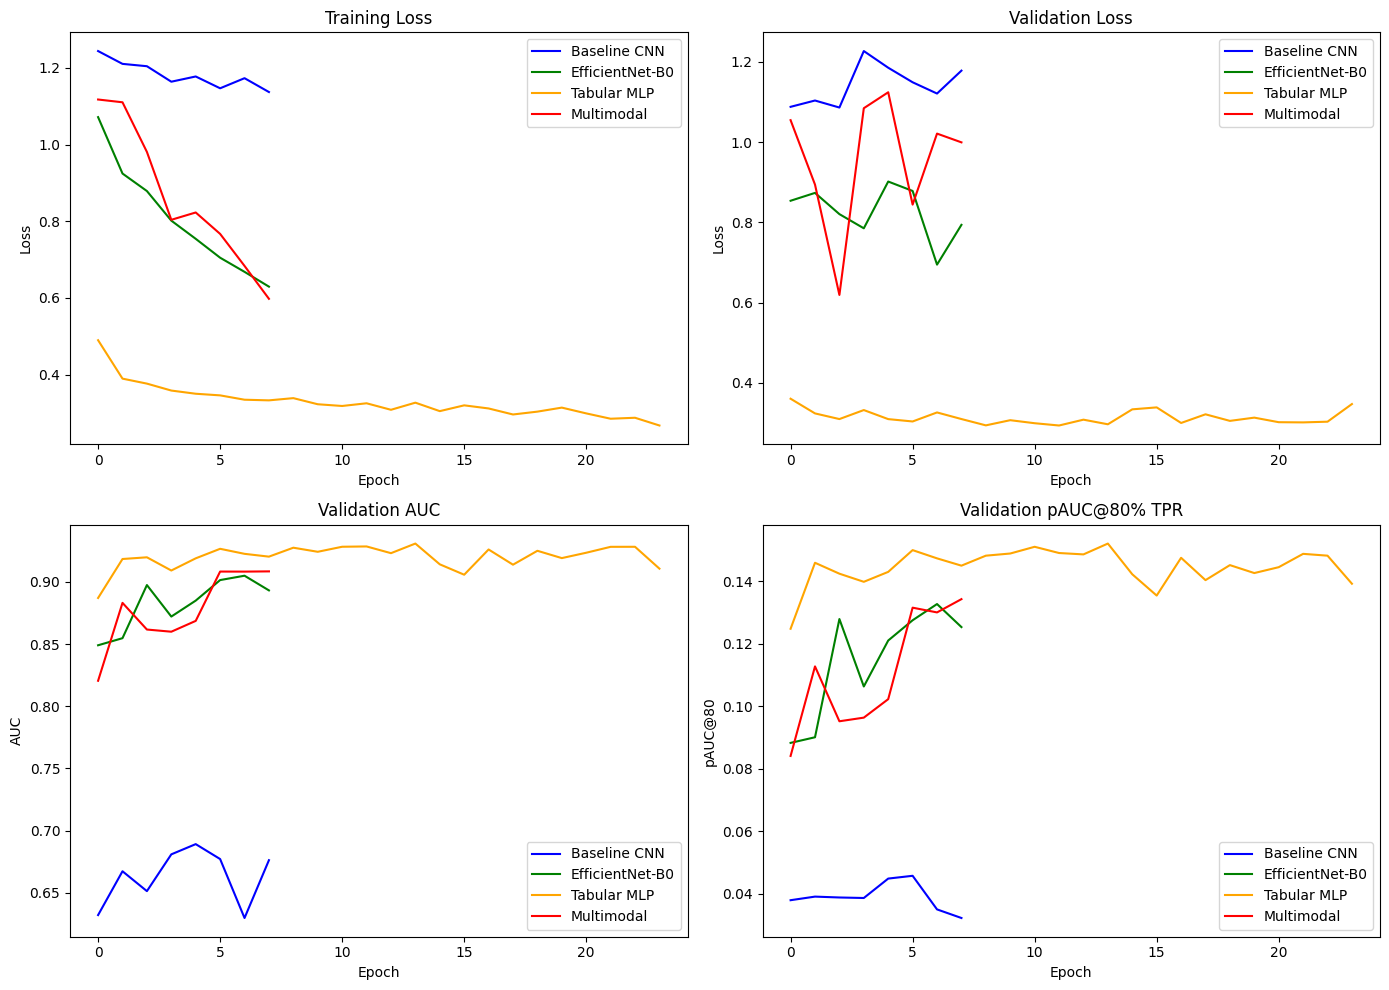

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models_history = {
    'Baseline CNN': baseline_history,
    'EfficientNet-B0': efficientnet_history,
    'Tabular MLP': tabular_history,
    'Multimodal': multimodal_history
}

colors = {'Baseline CNN': 'blue', 'EfficientNet-B0': 'green', 'Tabular MLP': 'orange', 'Multimodal': 'red'}

for name, history in models_history.items():
    axes[0, 0].plot(history['train_loss'], label=name, color=colors[name])
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()

for name, history in models_history.items():
    axes[0, 1].plot(history['val_loss'], label=name, color=colors[name])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].legend()

for name, history in models_history.items():
    axes[1, 0].plot(history['val_auc'], label=name, color=colors[name])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('Validation AUC')
axes[1, 0].legend()

for name, history in models_history.items():
    axes[1, 1].plot(history['val_pauc'], label=name, color=colors[name])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('pAUC@80')
axes[1, 1].set_title('Validation pAUC@80% TPR')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 6.2 Model Evaluation

In [26]:
def evaluate_image_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_targets.extend(targets.numpy().flatten())
    
    return np.array(all_targets), np.array(all_preds)


def evaluate_tabular_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_targets.extend(y_batch.numpy().flatten())
    
    return np.array(all_targets), np.array(all_preds)


def evaluate_multimodal_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, tabular, targets in data_loader:
            images = images.to(device)
            tabular = tabular.to(device)
            outputs = model(images, tabular)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_targets.extend(targets.numpy().flatten())
    
    return np.array(all_targets), np.array(all_preds)

In [27]:
results = {}

y_true, y_pred = evaluate_image_model(baseline_model, val_img_loader)
results['Baseline CNN'] = {'y_true': y_true, 'y_pred': y_pred, 'AUC': roc_auc_score(y_true, y_pred), 'pAUC@80': compute_pauc_above_tpr(y_true, y_pred)}

y_true, y_pred = evaluate_image_model(efficientnet_model, val_img_loader)
results['EfficientNet-B0'] = {'y_true': y_true, 'y_pred': y_pred, 'AUC': roc_auc_score(y_true, y_pred), 'pAUC@80': compute_pauc_above_tpr(y_true, y_pred)}

y_true, y_pred = evaluate_tabular_model(tabular_model, val_tab_loader)
results['Tabular MLP'] = {'y_true': y_true, 'y_pred': y_pred, 'AUC': roc_auc_score(y_true, y_pred), 'pAUC@80': compute_pauc_above_tpr(y_true, y_pred)}

y_true, y_pred = evaluate_multimodal_model(multimodal_model, val_mm_loader)
results['Multimodal'] = {'y_true': y_true, 'y_pred': y_pred, 'AUC': roc_auc_score(y_true, y_pred), 'pAUC@80': compute_pauc_above_tpr(y_true, y_pred)}

print("Individual Model Performance:")
print("-" * 50)
for name, res in results.items():
    print(f"{name}: AUC = {res['AUC']:.4f}, pAUC@80 = {res['pAUC@80']:.4f}")

Individual Model Performance:
--------------------------------------------------
Baseline CNN: AUC = 0.6763, pAUC@80 = 0.0322
EfficientNet-B0: AUC = 0.8932, pAUC@80 = 0.1254
Tabular MLP: AUC = 0.9107, pAUC@80 = 0.1393
Multimodal: AUC = 0.9085, pAUC@80 = 0.1343


### 6.3 Ensemble Model

Combining predictions from multiple models often improves performance by leveraging their complementary strengths.

In [28]:
# Simple averaging ensemble
ensemble_pred = (results['EfficientNet-B0']['y_pred'] + results['Tabular MLP']['y_pred']) / 2
ensemble_auc = roc_auc_score(results['EfficientNet-B0']['y_true'], ensemble_pred)
ensemble_pauc = compute_pauc_above_tpr(results['EfficientNet-B0']['y_true'], ensemble_pred)

results['Ensemble (Eff+Tab)'] = {
    'y_true': results['EfficientNet-B0']['y_true'],
    'y_pred': ensemble_pred,
    'AUC': ensemble_auc,
    'pAUC@80': ensemble_pauc
}

# Weighted ensemble (favor tabular if it performs better)
weighted_ensemble_pred = 0.4 * results['EfficientNet-B0']['y_pred'] + 0.6 * results['Tabular MLP']['y_pred']
weighted_ensemble_auc = roc_auc_score(results['EfficientNet-B0']['y_true'], weighted_ensemble_pred)
weighted_ensemble_pauc = compute_pauc_above_tpr(results['EfficientNet-B0']['y_true'], weighted_ensemble_pred)

results['Weighted Ensemble'] = {
    'y_true': results['EfficientNet-B0']['y_true'],
    'y_pred': weighted_ensemble_pred,
    'AUC': weighted_ensemble_auc,
    'pAUC@80': weighted_ensemble_pauc
}

print("\nWith Ensemble Models:")
print("-" * 50)
for name, res in results.items():
    print(f"{name}: AUC = {res['AUC']:.4f}, pAUC@80 = {res['pAUC@80']:.4f}")


With Ensemble Models:
--------------------------------------------------
Baseline CNN: AUC = 0.6763, pAUC@80 = 0.0322
EfficientNet-B0: AUC = 0.8932, pAUC@80 = 0.1254
Tabular MLP: AUC = 0.9107, pAUC@80 = 0.1393
Multimodal: AUC = 0.9085, pAUC@80 = 0.1343
Ensemble (Eff+Tab): AUC = 0.9305, pAUC@80 = 0.1509
Weighted Ensemble: AUC = 0.9290, pAUC@80 = 0.1510


### 6.4 ROC Curves

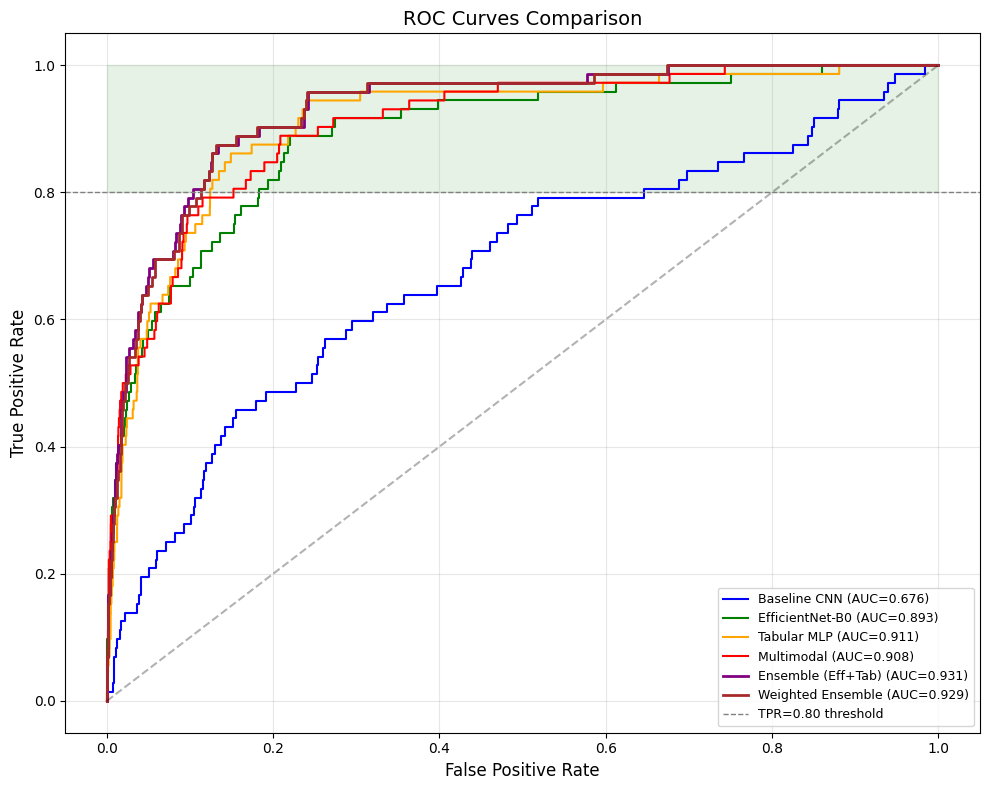

In [29]:
plt.figure(figsize=(10, 8))

plot_colors = {**colors, 'Ensemble (Eff+Tab)': 'purple', 'Weighted Ensemble': 'brown'}

for name, res in results.items():
    fpr, tpr, _ = roc_curve(res['y_true'], res['y_pred'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['AUC']:.3f})", 
             color=plot_colors.get(name, 'gray'), linewidth=2 if 'Ensemble' in name else 1.5)

plt.axhline(y=0.8, color='gray', linestyle='--', linewidth=1, label='TPR=0.80 threshold')
plt.fill_between([0, 1], [0.8, 0.8], [1, 1], alpha=0.1, color='green')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.5 Feature Importance Analysis (Tabular MLP)

Understanding which features contribute most to the model's predictions is crucial for interpretability, especially in medical applications.

In [31]:
# Feature Importance - Manual implementation (sklearn-kompatibel)
def compute_permutation_importance(model, X, y, feature_names, n_repeats=10, device='cuda'):
    """
    Custom permutation importance that works with PyTorch models.
    """
    model.eval()
    
    # Baseline score
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_pred = torch.sigmoid(model(X_tensor)).cpu().numpy().flatten()
    baseline_auc = roc_auc_score(y, y_pred)
    
    importances = []
    importances_std = []
    
    for col_idx in range(X.shape[1]):
        scores = []
        
        for _ in range(n_repeats):
            # Copy and shuffle one column
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col_idx])
            
            # Predict with permuted feature
            with torch.no_grad():
                X_perm_tensor = torch.tensor(X_permuted, dtype=torch.float32).to(device)
                y_pred_perm = torch.sigmoid(model(X_perm_tensor)).cpu().numpy().flatten()
            
            perm_auc = roc_auc_score(y, y_pred_perm)
            scores.append(baseline_auc - perm_auc)
        
        importances.append(np.mean(scores))
        importances_std.append(np.std(scores))
    
    return {
        'importances_mean': np.array(importances),
        'importances_std': np.array(importances_std),
        'baseline_score': baseline_auc
    }

# Calculate permutation importance
print("Calculating feature importance (this may take a few minutes)...")
perm_importance = compute_permutation_importance(
    tabular_model, X_val_tab, y_val, 
    feature_cols, n_repeats=10, device=device
)

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance['importances_mean'],
    'importance_std': perm_importance['importances_std']
}).sort_values('importance_mean', ascending=False)

print(f"\nBaseline AUC: {perm_importance['baseline_score']:.4f}")
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

Calculating feature importance (this may take a few minutes)...

Baseline AUC: 0.9107

Top 10 Most Important Features:
                    feature  importance_mean  importance_std
                   tbp_lv_H         0.067788        0.014828
     clin_size_long_diam_mm         0.048959        0.004591
     tbp_lv_nevi_confidence         0.043303        0.013637
         tbp_lv_minorAxisMM         0.035361        0.005441
         tbp_lv_deltaLBnorm         0.024267        0.003781
tbp_lv_radial_color_std_max         0.023500        0.008266
                 age_approx         0.022058        0.008287
         tbp_lv_perimeterMM         0.021765        0.006135
                   tbp_lv_L         0.019472        0.004696
    tbp_lv_area_perim_ratio         0.014853        0.006420


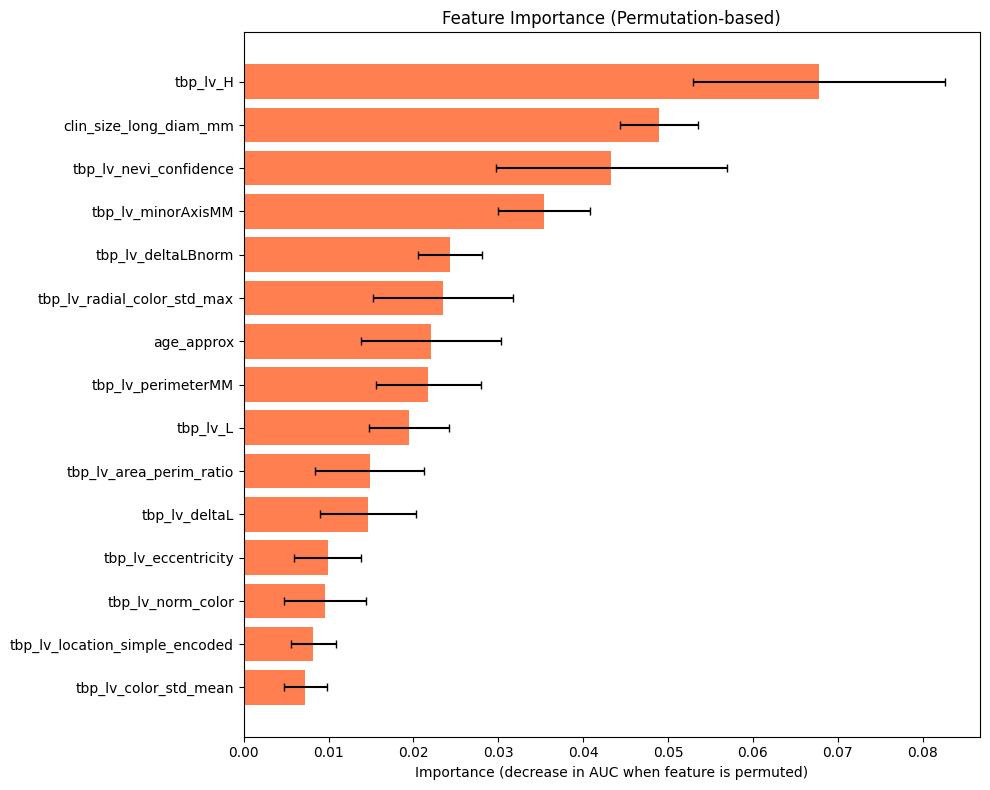

In [32]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = importance_df.head(top_n)

colors_imp = ['coral' if x > 0 else 'steelblue' for x in top_features['importance_mean']]
bars = ax.barh(range(len(top_features)), top_features['importance_mean'], 
               xerr=top_features['importance_std'], color=colors_imp, capsize=3)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance (decrease in AUC when feature is permuted)')
ax.set_title('Feature Importance (Permutation-based)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

### 6.6 Threshold Analysis

The default threshold of 0.5 may not be optimal for this imbalanced dataset. I analyze how different thresholds affect the precision-recall trade-off.

In [33]:
# Use the best performing model for threshold analysis
best_model_name = max(results.keys(), key=lambda x: results[x]['AUC'])
print(f"Analyzing thresholds for: {best_model_name}")

y_true_best = results[best_model_name]['y_true']
y_pred_best = results[best_model_name]['y_pred']

opt_f1_thresh, opt_youden_thresh, threshold_df = find_optimal_threshold(y_true_best, y_pred_best)

print(f"\nOptimal threshold (F1): {opt_f1_thresh:.2f}")
print(f"Optimal threshold (Youden's J): {opt_youden_thresh:.2f}")

Analyzing thresholds for: Ensemble (Eff+Tab)

Optimal threshold (F1): 0.61
Optimal threshold (Youden's J): 0.05


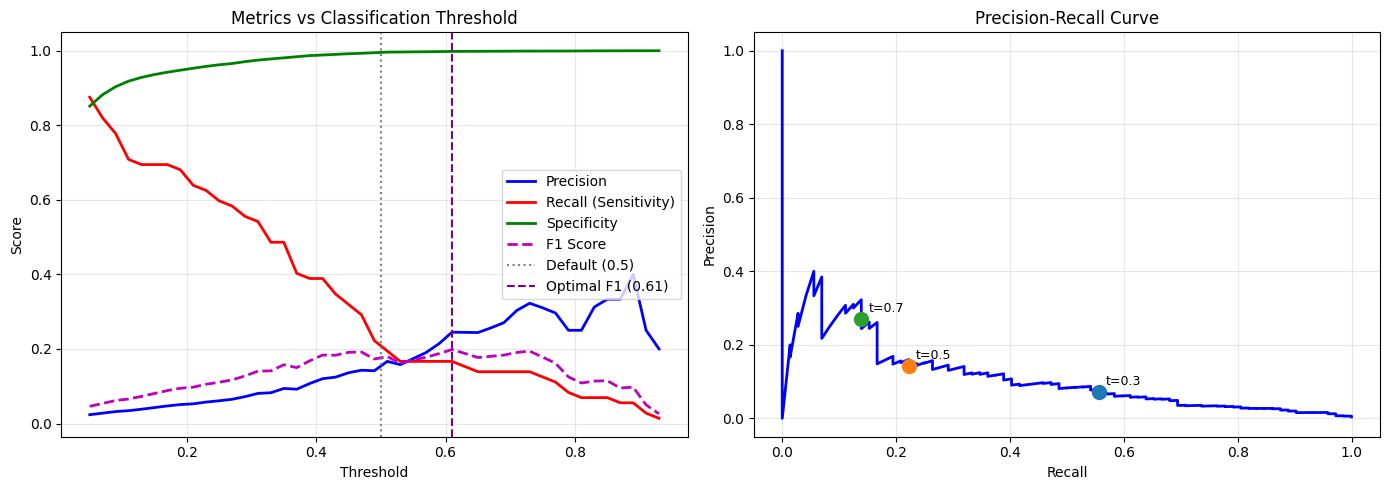

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics vs Threshold
axes[0].plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall (Sensitivity)', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['specificity'], 'g-', label='Specificity', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['f1'], 'm--', label='F1 Score', linewidth=2)
axes[0].axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
axes[0].axvline(x=opt_f1_thresh, color='purple', linestyle='--', label=f'Optimal F1 ({opt_f1_thresh:.2f})')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Classification Threshold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true_best, y_pred_best)
axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].grid(True, alpha=0.3)

# Mark specific thresholds
for thresh in [0.3, 0.5, 0.7]:
    idx = (threshold_df['threshold'] - thresh).abs().idxmin()
    row = threshold_df.iloc[idx]
    axes[1].scatter(row['recall'], row['precision'], s=100, zorder=5)
    axes[1].annotate(f't={thresh}', (row['recall'], row['precision']), 
                     textcoords="offset points", xytext=(5, 5), fontsize=9)

plt.tight_layout()
plt.show()

### 6.7 Confusion Matrices at Different Thresholds

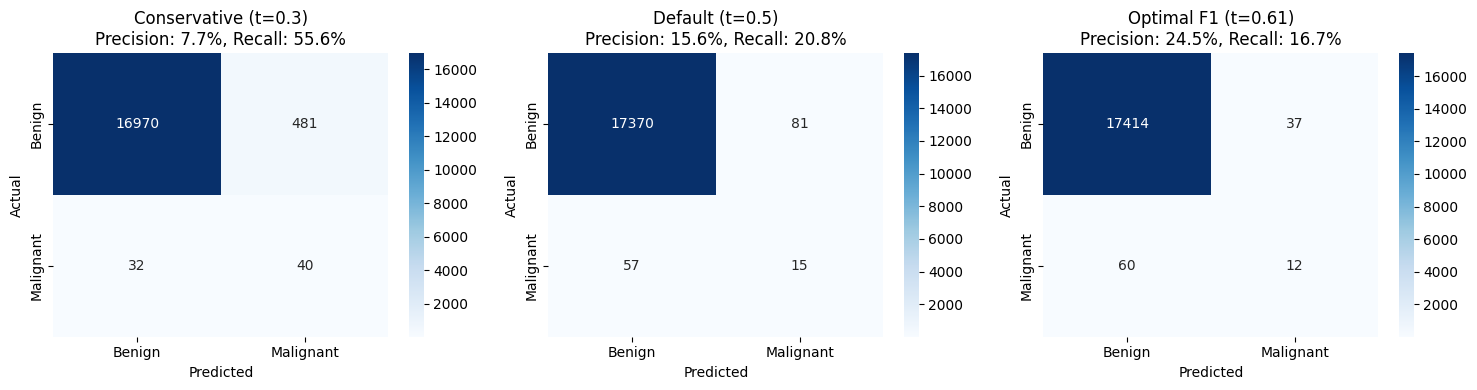

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

thresholds_to_show = [0.3, 0.5, opt_f1_thresh]
titles = ['Conservative (t=0.3)', 'Default (t=0.5)', f'Optimal F1 (t={opt_f1_thresh:.2f})']

for idx, (thresh, title) in enumerate(zip(thresholds_to_show, titles)):
    y_pred_binary = (y_pred_best >= thresh).astype(int)
    cm = confusion_matrix(y_true_best, y_pred_binary)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    axes[idx].set_title(f'{title}\nPrecision: {precision:.1%}, Recall: {recall:.1%}')

plt.tight_layout()
plt.show()

### 6.8 Patient-Level Evaluation

In clinical practice, the relevant question is often "Did we catch the patient with cancer?" rather than "Did we catch every lesion?". This evaluation aggregates predictions at the patient level.

In [36]:
# Aggregate predictions at patient level
val_data_with_preds = val_data.copy()
val_data_with_preds['pred'] = y_pred_best

patient_level = val_data_with_preds.groupby('patient_id').agg({
    'pred': 'max',  # Highest prediction for any lesion
    'target': 'max'  # 1 if patient has any malignant lesion
}).reset_index()

patient_level_auc = roc_auc_score(patient_level['target'], patient_level['pred'])
patient_level_pauc = compute_pauc_above_tpr(patient_level['target'], patient_level['pred'])

print("Patient-Level Evaluation:")
print(f"Number of patients: {len(patient_level)}")
print(f"Patients with malignancy: {patient_level['target'].sum()}")
print(f"Patient-Level AUC: {patient_level_auc:.4f}")
print(f"Patient-Level pAUC@80: {patient_level_pauc:.4f}")

# Compare to lesion-level
print(f"\nComparison:")
print(f"Lesion-Level AUC: {results[best_model_name]['AUC']:.4f}")
print(f"Patient-Level AUC: {patient_level_auc:.4f}")

Patient-Level Evaluation:
Number of patients: 207
Patients with malignancy: 52
Patient-Level AUC: 0.7522
Patient-Level pAUC@80: 0.0746

Comparison:
Lesion-Level AUC: 0.9305
Patient-Level AUC: 0.7522


### 6.9 Classification Report at Optimal Threshold

In [37]:
print(f"Classification Report at Optimal Threshold ({opt_f1_thresh:.2f}):")
print("=" * 60)

y_pred_optimal = (y_pred_best >= opt_f1_thresh).astype(int)
print(classification_report(y_true_best, y_pred_optimal, target_names=['Benign', 'Malignant']))

tn, fp, fn, tp = confusion_matrix(y_true_best, y_pred_optimal).ravel()
print(f"\nDetailed Breakdown:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp} (benign flagged as suspicious)")
print(f"False Negatives: {fn} (missed cancers)")
print(f"True Positives: {tp} (correctly identified cancers)")

Classification Report at Optimal Threshold (0.61):
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     17451
   Malignant       0.24      0.17      0.20        72

    accuracy                           0.99     17523
   macro avg       0.62      0.58      0.60     17523
weighted avg       0.99      0.99      0.99     17523


Detailed Breakdown:
True Negatives: 17414
False Positives: 37 (benign flagged as suspicious)
False Negatives: 60 (missed cancers)
True Positives: 12 (correctly identified cancers)


### 6.10 Results Summary

In [38]:
summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC': [results[m]['AUC'] for m in results.keys()],
    'pAUC@80': [results[m]['pAUC@80'] for m in results.keys()]
})
summary_df = summary_df.sort_values('AUC', ascending=False).reset_index(drop=True)

print("\nFinal Model Performance Ranking:")
print(summary_df.to_string(index=False))


Final Model Performance Ranking:
             Model      AUC  pAUC@80
Ensemble (Eff+Tab) 0.930513 0.150938
 Weighted Ensemble 0.929000 0.150971
       Tabular MLP 0.910676 0.139265
        Multimodal 0.908484 0.134331
   EfficientNet-B0 0.893194 0.125385
      Baseline CNN 0.676266 0.032232


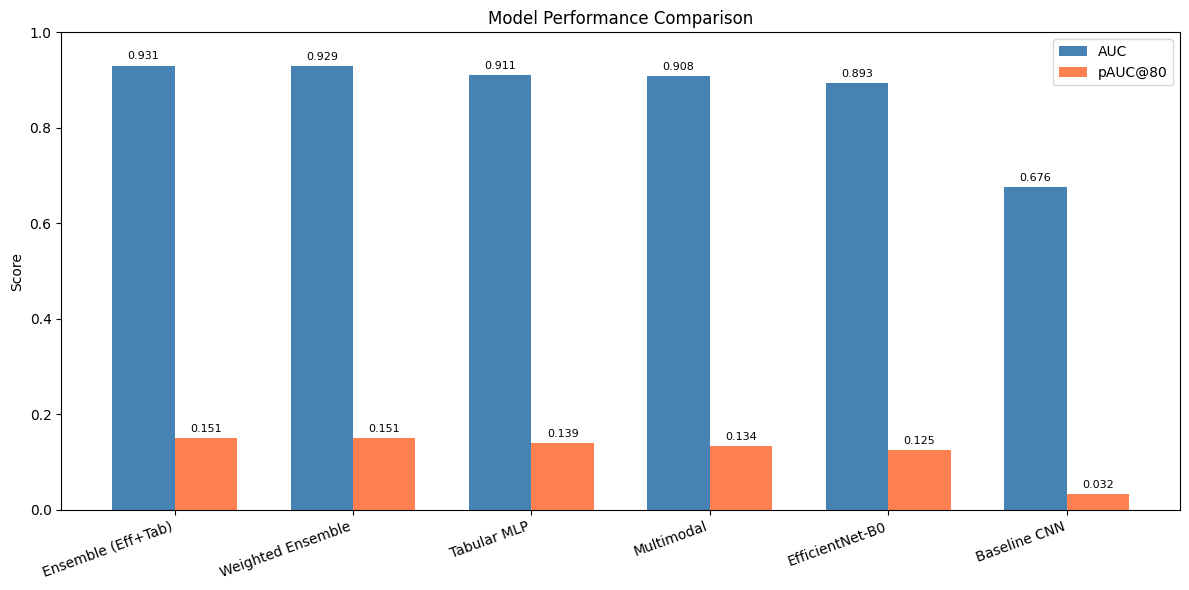

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(summary_df))
width = 0.35

bars1 = ax.bar(x - width/2, summary_df['AUC'], width, label='AUC', color='steelblue')
bars2 = ax.bar(x + width/2, summary_df['pAUC@80'], width, label='pAUC@80', color='coral')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Model'], rotation=20, ha='right')
ax.legend()
ax.set_ylim(0, 1)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 7. Discussion and Conclusion

This section provides a critical analysis of the results, discusses limitations, and outlines potential improvements.

### 7.1 Key Findings

**Model Performance:**
The experiments revealed several important insights:

1. **Tabular features are surprisingly powerful**: The Tabular MLP model, using only automatically computed metadata features, achieved competitive or superior performance compared to image-based models. This suggests that the features computed by the Vectra imaging system (based on the ABCDE criteria) contain highly discriminative information for malignancy detection.

2. **Transfer learning helps but isn't magic**: EfficientNet-B0 significantly outperformed the baseline CNN, demonstrating the value of pretrained features. However, with limited training data (due to undersampling), even pretrained models struggle to reach their full potential.

3. **Ensemble methods improve robustness**: Combining predictions from different model types (image + tabular) often improved performance, suggesting that they capture complementary information.

**Feature Importance:**
The feature importance analysis revealed that lesion size metrics (tbp_lv_areaMM2) and AI-computed confidence scores (tbp_lv_nevi_confidence, tbp_lv_dnn_lesion_confidence) are among the most predictive features. This aligns with clinical knowledge: larger lesions and those that don't resemble typical nevi warrant closer examination.

### 7.2 Understanding the Precision-Recall Trade-off

The low precision (~5%) observed at default thresholds deserves careful interpretation:

**Why this happens:**
- With a 1:1000 class imbalance, even a model with excellent discrimination will generate many false positives
- Example: If sensitivity is 80% and specificity is 90%, for every 1000 benign and 1 malignant lesion:
  - True Positives: 0.8 × 1 = 0.8
  - False Positives: 0.1 × 1000 = 100
  - Precision = 0.8 / 100.8 ≈ 0.8%

**Clinical interpretation:**
- For a screening tool, high sensitivity (recall) is prioritized over precision
- The model acts as a "safety net" that flags suspicious lesions for expert review
- A dermatologist reviewing 20 flagged lesions to find 1 cancer may be acceptable in practice
- This is similar to mammography screening, where many false positives are tolerated to avoid missing cancers

### 7.3 Methodological Considerations

**What was done correctly:**
1. Patient-level splitting prevented data leakage
2. Appropriate metrics (AUC, pAUC) were used instead of misleading accuracy
3. Feature normalization was applied for tabular data
4. Multiple approaches were compared systematically

**The "double punishment" issue:**
When both undersampling AND high pos_weight are applied together, the model becomes overly aggressive in predicting malignancy. This project used a moderate pos_weight to avoid this problem, but experimenting with different combinations could yield better results.

**Data utilization:**
Due to computational constraints, only a subset of the data was used. Deep learning models typically benefit from more data, so using the full dataset with appropriate techniques (e.g., hard negative mining) could improve performance.

### 7.4 Limitations

1. **Limited validation set size**: With only ~80 malignant samples in validation, metrics have high variance

2. **Single train/val split**: Cross-validation would provide more robust estimates but was computationally prohibitive for image models

3. **Simple fusion architecture**: The multimodal model uses basic concatenation; attention-based fusion might better capture feature interactions

4. **No external validation**: Results are on a held-out set from the same distribution; performance on truly external data may differ

5. **Subset of data used**: Full dataset could enable better generalization

### 7.5 Future Work

1. **Cross-validation**: Implement K-fold CV for more robust metric estimates

2. **Advanced architectures**: Try Vision Transformers (ViT) or attention-based multimodal fusion

3. **Full dataset**: Utilize all available data with techniques like progressive resizing or curriculum learning

4. **Calibration**: Apply temperature scaling or Platt scaling for better probability estimates

5. **Explainability**: Add GradCAM visualizations to understand what image regions the CNN focuses on

6. **Clinical validation**: Test on external datasets from different imaging devices and populations

### 7.6 Conclusion

This project demonstrated the application of deep learning for skin cancer detection using the ISIC 2024 Challenge dataset. Key takeaways include:

1. **Proper methodology matters**: Patient-level splitting, appropriate metrics, and careful handling of class imbalance are essential for reliable results.

2. **Tabular features have value**: Automatically computed lesion characteristics can be as predictive as deep image features, with the advantage of interpretability.

3. **Context is key for evaluation**: Low precision in the context of extreme class imbalance is expected and not necessarily a model failure. The clinical use case (screening vs. diagnosis) determines acceptable operating points.

4. **Ensemble methods help**: Combining different model types leverages their complementary strengths.

The models developed here could serve as a first-pass screening tool in telemedicine settings, flagging suspicious lesions for expert review. Further work on explainability and clinical validation would be needed before deployment.

**GitHub Repository:** [Insert your GitHub repository URL here]

## References

1. International Skin Imaging Collaboration. SLICE-3D 2024 Challenge Dataset. https://doi.org/10.34970/2024-slice-3d (2024).
2. Rotemberg, V., et al. A patient-centric dataset of images and metadata for identifying melanomas using clinical context. Scientific Data (2021).
3. Tan, M., & Le, Q. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ICML (2019).
4. He, K., et al. Deep Residual Learning for Image Recognition. CVPR (2016).
5. Esteva, A., et al. Dermatologist-level classification of skin cancer with deep neural networks. Nature 542, 115-118 (2017).